# Import libraries

In [2]:
import numpy as np                 # Scientific Computation
import pandas as pd                # Loading and Manipulating Datasets
import matplotlib.pyplot as plt    # Plotting Graphs
import math
from keras.models import Sequential, Model
from keras.layers import Input, Dense, LSTM, Activation
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import concatenate
from keras.layers import Reshape
from keras.layers.core import RepeatVector
from sklearn.preprocessing import StandardScaler

Using TensorFlow backend.


# Import Train Data and Preprocessing

In [9]:
dataset = pd.read_csv('S&P500_train.csv')
dataset_train = dataset.iloc[:,1:7].values
dataset_train.shape

(4300, 6)

In [10]:
sc = StandardScaler()
data_train=[]
for i in range(5,4300+1):
    data_train.append(dataset_train[i-5:i,:])       

data_train_scaled = []
for w in data_train:
    norm_win = sc.fit_transform(w)
    data_train_scaled.append(norm_win)
data_train_scaled = np.array(data_train_scaled)
data_train_scaled.shape

(4296, 5, 6)

## Train data

In [11]:
x_train = data_train_scaled[0:4295,:,:]
y_train = data_train_scaled[1:4296,4,:]
print(x_train.shape)
print(y_train.shape)

(4295, 5, 6)
(4295, 6)


In [22]:
y_train=np.expand_dims(y_train, axis=1)
print(x_train.shape)
print(y_train.shape)

(4295, 5, 6)
(4295, 1, 6)


# Model Parameters

In [14]:
feature_size=6
step_time=5
gan_input_dim=(step_time,feature_size)

# Create GAN

### Optimizer

In [12]:
def get_optimizer():
    return Adam(lr = 0.01, beta_1 = 0.5) 

### Discriminator

In [8]:
def get_discriminator(optimizer,step_time,feature_size):
    discriminator = Sequential()
    discriminator.add(Dense(units = 72,input_dim=(step_time+1)*feature_size))
    discriminator.add(LeakyReLU(alpha = 0.2))
    discriminator.add(Dense(units = 100))
    discriminator.add(LeakyReLU(alpha = 0.2))
    discriminator.add(Dense(units = 10))
    discriminator.add(LeakyReLU(alpha = 0.2))
    discriminator.add(Dense(units = 1,activation = 'sigmoid'))
    discriminator.compile(loss ='binary_crossentropy', optimizer = optimizer)
    return discriminator

### Generator

In [9]:
def get_generator(optimizer,feature_size):
    generator = Sequential()
    generator.add(LSTM(units = 10, return_sequences = False, input_shape = (x_train.shape[1], feature_size)))
    generator.add(Dense(units = feature_size))
    generator.add(LeakyReLU(alpha = 0.2))
    generator.add(RepeatVector(1))
    generator.compile(loss ='mse', optimizer = optimizer)
    return generator

### GAN

In [10]:
def get_gan_network(discriminator, gan_input_dim, generator, optimizer):
    # We initially set trainable to False since we only want to train either the generator or discriminator at a time
    discriminator.trainable = False
    
    gan_input = Input(shape=gan_input_dim)
    x = generator(gan_input)
    # Concatenate the output of the generator with real data
    val=concatenate(inputs=[gan_input,x],axis=1)
    R=Reshape((36,))(val)
    gan_output = discriminator(R)
    
    gan = Model(inputs = gan_input, outputs = gan_output)
    gan.compile(loss ='binary_crossentropy', optimizer = optimizer)
    return gan

## My own loss

Epoch 1/10
4295/4295 [==============================] - 6s 1ms/step - loss: 1.0131 - acc: 0.4293
Epoch 2/10
4295/4295 [==============================] - 4s 1ms/step - loss: 0.8293 - acc: 0.4643
Epoch 3/10
4295/4295 [==============================] - 4s 1ms/step - loss: 0.7736 - acc: 0.4603
Epoch 4/10
4295/4295 [==============================] - 4s 1ms/step - loss: 0.7463 - acc: 0.4603
Epoch 5/10
4295/4295 [==============================] - 4s 1ms/step - loss: 0.7328 - acc: 0.4610
Epoch 6/10
4295/4295 [==============================] - 4s 1ms/step - loss: 0.7266 - acc: 0.4631
Epoch 7/10
4295/4295 [==============================] - 4s 1ms/step - loss: 0.7227 - acc: 0.4654
Epoch 8/10
4295/4295 [==============================] - 5s 1ms/step - loss: 0.7183 - acc: 0.4643
Epoch 9/10
4295/4295 [==============================] - 4s 1ms/step - loss: 0.7158 - acc: 0.4587
Epoch 10/10
4295/4295 [==============================] - 5s 1ms/step - loss: 0.7139 - acc: 0.4596


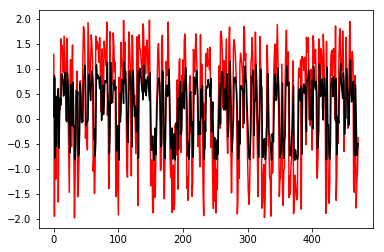

In [28]:
# Build a model
import keras.backend as K
# inputs = Input(shape=(128,))
# layer1 = Dense(64, activation='relu')(inputs)
# layer2 = Dense(64, activation='relu')(layer1)
# predictions = Dense(10, activation='softmax')(layer2)
# model = Model(inputs=inputs, outputs=predictions)
generator = Sequential()
generator.add(LSTM(units = 10, return_sequences = False, input_shape = (x_train.shape[1], feature_size)))
generator.add(Dense(units = feature_size))
generator.add(LeakyReLU(alpha = 0.2))
generator.add(RepeatVector(1))

# Define custom loss
def custom_loss():

    # Create a loss function that adds the MSE loss to the mean of all squared activations of a specific layer
    def loss(y_true,y_pred):
        return 0.5*K.mean(K.square(y_pred - y_true), axis=-1)
    
   
    # Return a function
    return loss
    
# Compile the model
generator.compile(optimizer='adam',
              loss=custom_loss(), # Call the loss function with the selected layer
              metrics=['accuracy'])

# train
generator.fit(x_train, y_train,batch_size=5, epochs=10)
predicted = generator.predict(x_test)
plt.plot(y_test[:,0,3],color = 'red')
plt.plot(predicted[:,0,3],color = 'black')


In [25]:
y_train.shape
predicted.shape

(472, 1, 6)

# Train GAN

In [11]:
def train(epochs,step_time,feature_size,gan_input_dim,batch_size=30):
    
    batch_count = x_train.shape[0] // batch_size
    
    adam = get_optimizer()
    generator = get_generator(adam,feature_size)
    discriminator = get_discriminator(adam,step_time,feature_size)
    gan = get_gan_network(discriminator, gan_input_dim, generator, adam)
    
    for e in range(1, epochs+1):
        D_loss=[]
        G_loss=[]
        # Train the Network in Batchs
        for i in range (0,batch_count):
            X_tr_batch = x_train[i*batch_size:(i+1)*batch_size,:,:]
            Y_tr_batch = y_train[i*batch_size:(i+1)*batch_size,:,:]
            pred = generator.predict(X_tr_batch)

            X_real = np.concatenate((X_tr_batch, Y_tr_batch),axis=1)
            X_real = np.reshape(X_real,(-1,36,))
            X_fake = np.concatenate((X_tr_batch, pred),axis=1)
            X_fake = np.reshape(X_fake,(-1,36,))

            fake = np.zeros((batch_size,1))
            real = np.ones((batch_size,1))
            
            # Train discriminator
            discriminator.trainable = True
    
            d_loss_real = discriminator.train_on_batch(X_real, real)

            d_loss_fake = discriminator.train_on_batch(X_fake, fake)
            d_loss=np.add(d_loss_real,d_loss_fake)
            D_loss.append(d_loss)

    
            # Train generator
            discriminator.trainable = False
            y_gen = np.zeros((batch_size,1))
            g_loss=gan.train_on_batch(X_tr_batch, y_gen)
            G_loss.append(g_loss)
            # Print the Results
            print ("epoch : %d , batch : %d , D loss : %f , G loss : %f" % (e,i, d_loss,g_loss))
    return gan,generator,discriminator,D_loss,G_loss

In [12]:
# Train the GAN Network
if __name__ == '__main__':
    gan1,generator1,discriminator1,D_loss,G_loss=train(5,step_time,feature_size,gan_input_dim,30)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
epoch : 1 , batch : 0 , D loss : 2.267150 , G loss : 1.020267
epoch : 1 , batch : 1 , D loss : 1.430903 , G loss : 0.755049
epoch : 1 , batch : 2 , D loss : 1.307129 , G loss : 0.695174
epoch : 1 , batch : 3 , D loss : 1.277173 , G loss : 0.678330
epoch : 1 , batch : 4 , D loss : 1.101771 , G loss : 0.640757
epoch : 1 , batch : 5 , D loss : 1.265862 , G loss : 0.640341
epoch : 1 , batch : 6 , D loss : 0.858163 , G loss : 0.567750
epoch : 1 , batch : 7 , D loss : 1.015719 , G loss : 0.511858
epoch : 1 , batch : 8 , D loss : 0.702815 , G loss : 0.266441
epoch : 1 , batch : 9 , D loss : 0.685674 , G loss : 0.178346
epoch : 1 , batch : 10 , D loss : 0.333624 , G loss : 0.084091
epoch : 1 , batch : 11 , D loss : 0.403166 , G loss : 0.071133
epoch : 1 , batch : 12 , D loss : 0.245466 , G loss : 0.018340
epoch : 1 , batch : 13 , D loss : 0.629196 , G loss : 0.068684
epoch : 

epoch : 1 , batch : 121 , D loss : 0.000013 , G loss : 0.000009
epoch : 1 , batch : 122 , D loss : 0.000015 , G loss : 0.000011
epoch : 1 , batch : 123 , D loss : 0.000016 , G loss : 0.000014
epoch : 1 , batch : 124 , D loss : 0.000035 , G loss : 0.000010
epoch : 1 , batch : 125 , D loss : 0.000033 , G loss : 0.000012
epoch : 1 , batch : 126 , D loss : 0.000035 , G loss : 0.000014
epoch : 1 , batch : 127 , D loss : 0.000014 , G loss : 0.000007
epoch : 1 , batch : 128 , D loss : 0.000140 , G loss : 0.000014
epoch : 1 , batch : 129 , D loss : 0.000042 , G loss : 0.000007
epoch : 1 , batch : 130 , D loss : 0.000022 , G loss : 0.000015
epoch : 1 , batch : 131 , D loss : 0.000012 , G loss : 0.000010
epoch : 1 , batch : 132 , D loss : 0.000017 , G loss : 0.000008
epoch : 1 , batch : 133 , D loss : 0.000068 , G loss : 0.000010
epoch : 1 , batch : 134 , D loss : 0.000028 , G loss : 0.000009
epoch : 1 , batch : 135 , D loss : 0.000024 , G loss : 0.000010
epoch : 1 , batch : 136 , D loss : 0.000

epoch : 2 , batch : 117 , D loss : 0.000019 , G loss : 0.000004
epoch : 2 , batch : 118 , D loss : 0.000005 , G loss : 0.000005
epoch : 2 , batch : 119 , D loss : 0.000031 , G loss : 0.000004
epoch : 2 , batch : 120 , D loss : 0.000003 , G loss : 0.000002
epoch : 2 , batch : 121 , D loss : 0.000003 , G loss : 0.000002
epoch : 2 , batch : 122 , D loss : 0.000004 , G loss : 0.000002
epoch : 2 , batch : 123 , D loss : 0.000004 , G loss : 0.000003
epoch : 2 , batch : 124 , D loss : 0.000009 , G loss : 0.000002
epoch : 2 , batch : 125 , D loss : 0.000010 , G loss : 0.000003
epoch : 2 , batch : 126 , D loss : 0.000011 , G loss : 0.000004
epoch : 2 , batch : 127 , D loss : 0.000004 , G loss : 0.000002
epoch : 2 , batch : 128 , D loss : 0.000033 , G loss : 0.000003
epoch : 2 , batch : 129 , D loss : 0.000006 , G loss : 0.000002
epoch : 2 , batch : 130 , D loss : 0.000005 , G loss : 0.000003
epoch : 2 , batch : 131 , D loss : 0.000003 , G loss : 0.000003
epoch : 2 , batch : 132 , D loss : 0.000

epoch : 3 , batch : 114 , D loss : 0.000007 , G loss : 0.000001
epoch : 3 , batch : 115 , D loss : 0.000007 , G loss : 0.000002
epoch : 3 , batch : 116 , D loss : 0.000002 , G loss : 0.000001
epoch : 3 , batch : 117 , D loss : 0.000010 , G loss : 0.000002
epoch : 3 , batch : 118 , D loss : 0.000003 , G loss : 0.000002
epoch : 3 , batch : 119 , D loss : 0.000018 , G loss : 0.000002
epoch : 3 , batch : 120 , D loss : 0.000001 , G loss : 0.000001
epoch : 3 , batch : 121 , D loss : 0.000001 , G loss : 0.000001
epoch : 3 , batch : 122 , D loss : 0.000002 , G loss : 0.000001
epoch : 3 , batch : 123 , D loss : 0.000002 , G loss : 0.000002
epoch : 3 , batch : 124 , D loss : 0.000004 , G loss : 0.000001
epoch : 3 , batch : 125 , D loss : 0.000005 , G loss : 0.000001
epoch : 3 , batch : 126 , D loss : 0.000006 , G loss : 0.000002
epoch : 3 , batch : 127 , D loss : 0.000002 , G loss : 0.000001
epoch : 3 , batch : 128 , D loss : 0.000014 , G loss : 0.000002
epoch : 3 , batch : 129 , D loss : 0.000

epoch : 4 , batch : 105 , D loss : 0.000001 , G loss : 0.000001
epoch : 4 , batch : 106 , D loss : 0.000018 , G loss : 0.000001
epoch : 4 , batch : 107 , D loss : 0.000003 , G loss : 0.000001
epoch : 4 , batch : 108 , D loss : 0.000001 , G loss : 0.000001
epoch : 4 , batch : 109 , D loss : 0.000004 , G loss : 0.000001
epoch : 4 , batch : 110 , D loss : 0.000013 , G loss : 0.000002
epoch : 4 , batch : 111 , D loss : 0.000002 , G loss : 0.000001
epoch : 4 , batch : 112 , D loss : 0.000001 , G loss : 0.000001
epoch : 4 , batch : 113 , D loss : 0.000017 , G loss : 0.000001
epoch : 4 , batch : 114 , D loss : 0.000004 , G loss : 0.000001
epoch : 4 , batch : 115 , D loss : 0.000004 , G loss : 0.000001
epoch : 4 , batch : 116 , D loss : 0.000001 , G loss : 0.000001
epoch : 4 , batch : 117 , D loss : 0.000006 , G loss : 0.000001
epoch : 4 , batch : 118 , D loss : 0.000002 , G loss : 0.000001
epoch : 4 , batch : 119 , D loss : 0.000012 , G loss : 0.000001
epoch : 4 , batch : 120 , D loss : 0.000

epoch : 5 , batch : 99 , D loss : 0.000002 , G loss : 0.000000
epoch : 5 , batch : 100 , D loss : 0.000002 , G loss : 0.000001
epoch : 5 , batch : 101 , D loss : 0.000002 , G loss : 0.000001
epoch : 5 , batch : 102 , D loss : 0.000001 , G loss : 0.000000
epoch : 5 , batch : 103 , D loss : 0.000002 , G loss : 0.000000
epoch : 5 , batch : 104 , D loss : 0.000002 , G loss : 0.000001
epoch : 5 , batch : 105 , D loss : 0.000001 , G loss : 0.000000
epoch : 5 , batch : 106 , D loss : 0.000012 , G loss : 0.000000
epoch : 5 , batch : 107 , D loss : 0.000002 , G loss : 0.000001
epoch : 5 , batch : 108 , D loss : 0.000001 , G loss : 0.000001
epoch : 5 , batch : 109 , D loss : 0.000003 , G loss : 0.000001
epoch : 5 , batch : 110 , D loss : 0.000009 , G loss : 0.000001
epoch : 5 , batch : 111 , D loss : 0.000001 , G loss : 0.000001
epoch : 5 , batch : 112 , D loss : 0.000001 , G loss : 0.000000
epoch : 5 , batch : 113 , D loss : 0.000011 , G loss : 0.000001
epoch : 5 , batch : 114 , D loss : 0.0000

## Plot D_loss

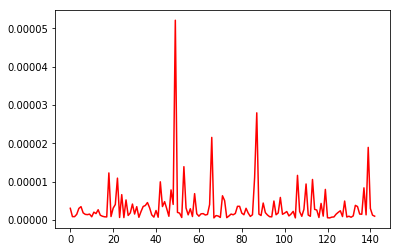

In [13]:
D_loss=np.array(D_loss)
plt.plot(D_loss, color = 'red')

## Plot G_loss

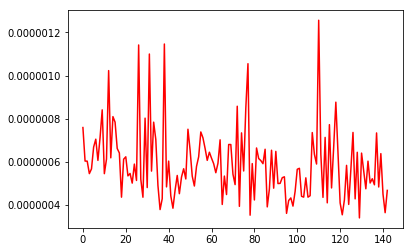

In [14]:
G_loss=np.array(G_loss)
plt.plot(G_loss, color = 'red')

# Import Test Data

In [16]:
dataset = pd.read_csv('S&P500_test.csv')
dataset_test = dataset.iloc[:,1:7].values

data_test=[]
for i in range(5,477+1):
    data_test.append(dataset_test[i-5:i,:])       

data_test_scaled = []
for w in data_test:
    norm_win = sc.fit_transform(w)
    data_test_scaled.append(norm_win)
data_test_scaled = np.array(data_test_scaled)
data_test_scaled.shape

(473, 5, 6)

In [26]:
x_test = data_test_scaled[0:472,:,:]
y_test = data_test_scaled[1:473,4,:]
y_test=np.expand_dims(y_test, axis=1)
print(x_test.shape)
print(y_test.shape)

(472, 5, 6)
(472, 1, 6)


In [17]:
len(data_test)

473

# Testing our GAN

In [18]:
predicted = generator1.predict(x_test)

# Inverse Transform the Results

In [19]:
predicted.shape

(472, 1, 6)

In [20]:
X_inverse = []
inverse_y_test=[]
inverse_predicted=[]
i=0
for w in data_test:
    if i>471:
        break
    sc.fit(w)
    inverse_y_test.append(sc.inverse_transform(y_test[i,:,:]))
    inverse_predicted.append(sc.inverse_transform(predicted[i,:,:]))
    i+=1
inverse_y_test=np.array(inverse_y_test)
inverse_predicted=np.array(inverse_predicted)

# Plot the Results 

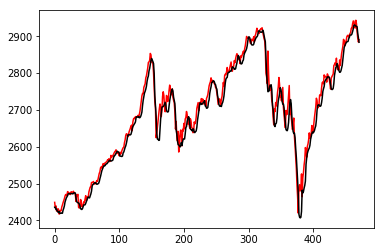

In [21]:
plt.plot(inverse_y_test[:,0,3],color = 'red')
plt.plot(inverse_predicted[:,0,3],color = 'black')

# Indicators

### MAE

In [22]:
N = 471
a = abs(inverse_y_test[:,0,3]-inverse_predicted[:,0,3]) #close s&p500
MAE = a[0]
for i in range(1,471):
    MAE = a[i] + MAE
MAE = MAE/N
MAE  

19.25587312118809

### RMSE

In [23]:
RMSE = a[0]**2
for i in range(1,471):
    RMSE = a[i]**2 + RMSE
RMSE = RMSE/N
math.sqrt(RMSE)

25.87764976862301

### MAPE

In [24]:
MAPE = a[0]/inverse_y_test[:,0,3][0]
for i in range(0,471):
    MAPE = MAPE + a[i]/inverse_y_test[:,0,3][i]
MAPE = MAPE/N 
MAPE

0.007166202060093379

### AR

In [25]:
for i in range(1,470):
    if inverse_predicted[:,0,3][i+1] > inverse_predicted[:,0,3][i]:
        AR = inverse_y_test[:,0,3][1]-inverse_y_test[:,0,3][0]
        AR = AR + (inverse_y_test[:,0,3][i+1]-inverse_y_test[:,0,3][i])
        AR = AR/(N-1)
AR

-0.06644877265644608